In [360]:
import numpy as np
import skimage.transform
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import os
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest' 
matplotlib.rcParams['image.cmap'] = 'gray'

Populating the interactive namespace from numpy and matplotlib


## Dictionary to map file keys from STScI to Krist

In [361]:
telap_key_map = {'hex1':'hex1', 'hex2':'hex2', 'hex3':'hex3', 'hex4':'hex4',
                 'key24':'keystone24', 'pie08':'piewedge8', 'pie12':'piewedge12'}
secobs_key_map = {'Cross':'cross', 'X':'x'}

## Set basic parameters

In [390]:
N = 125 # pupil array quadrant width after binning
iD = 25
oD = 80
spad = 10
aligntol = 5
#prim_key = "hex1"
secobs_key = "X"
centobs = True
D = 1000 # starting aperture diameter

In [392]:
#LS_dir = os.path.abspath("../InputMasks/LS")
LS_dir = os.path.abspath("/astro/opticslab1/SCDA/Apertures/InputMasks/LS")
if not os.path.exists(LS_dir):
    os.mkdir(LS_dir)
    print("created {:s} for LS arrays".format(LS_dir))
else:
    print("Destination {:s} already exists".format(LS_dir))

Destination /astro/opticslab1/SCDA/Apertures/InputMasks/LS already exists


## Load secondary obscuration

In [393]:
#telap_dir = os.path.abspath('../Apertures/JPL/offset_masks')
telap_dir = os.path.abspath('/astro/opticslab1/SCDA/Apertures/JPL/offset_masks')
if centobs is True:
#    telap_fname = os.path.join(telap_dir, "{0:s}_{1:04d}pix_offset.fits".format(
#                                           telap_key_map[prim_key], D))
    secobs_fname = os.path.join(telap_dir, "{0:s}_spiders_{1:04d}pix_2.5cm_offset.fits".format(
                                            secobs_key_map[secobs_key], D))
else:
#    telap_fname = os.path.join(telap_dir, "{0:s}_{1:04d}pix_offset_no_central_obsc.fits".format(
#                                           telap_key_map[prim_key], D))
    secobs_fname = os.path.join(telap_dir, "{0:s}_spiders_{1:04d}pix_2.5cm_offset.fits".format(
                                            secobs_key_map[secobs_key], D))
#telap_hdulist = fits.open(telap_fname, "readonly")
#telap_orig = telap_hdulist[0].data
#telap_hdulist.close()
secobs_hdulist = fits.open(secobs_fname, "readonly")
secobs = secobs_hdulist[0].data
secobs_hdulist.close()
obstelap = secobs

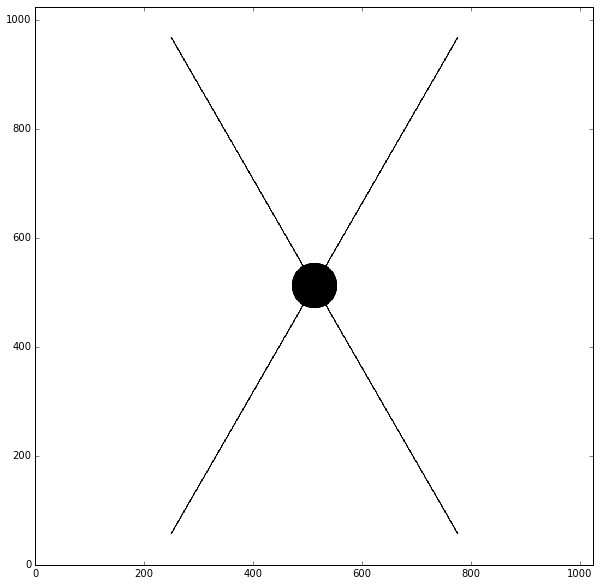

In [394]:
plt.figure(figsize=(10,10))
plt.imshow(secobs)

## Pad the secondary obscuration

In [395]:
spad_fac = float(spad)/1000
max_shift = int(round(D*spad_fac))
shift_range = range(-max_shift,max_shift+1,1)
[Xshifts, Yshifts] = np.meshgrid(shift_range, shift_range)
allowed_shifts = np.less_equal(Xshifts**2 + Yshifts**2, max_shift**2)
XYshifts_allowed = zip(Xshifts[allowed_shifts], Yshifts[allowed_shifts])
len(XYshifts_allowed)

317

In [396]:
padded_secobs_accum = np.ones(secobs.shape)
for (xshift,yshift) in XYshifts_allowed:
    secobs_shifted = np.roll(np.roll(secobs, yshift, 0), xshift, 1) 
    padded_secobs_accum *= secobs_shifted

In [397]:
#plt.figure(figsize=(10,10))
#plt.imshow(padded_secobs_accum)

## Combine with annular stop

In [398]:
L = secobs.shape[0]
inD = float(iD)/100
outD = float(oD)/100
xs = np.linspace(-L/2 + 0.5, L/2 - 0.5, L)
[Xs, Ys] = np.meshgrid(xs, xs)
inside_ann = np.less_equal(Xs**2 + Ys**2, (inD*D/2)**2)
outside_ann = np.greater_equal(Xs**2 + Ys**2, (outD*D/2)**2)
Lyot_stop = np.round(padded_secobs_accum)
Lyot_stop[inside_ann] = 0.
Lyot_stop[outside_ann] = 0.

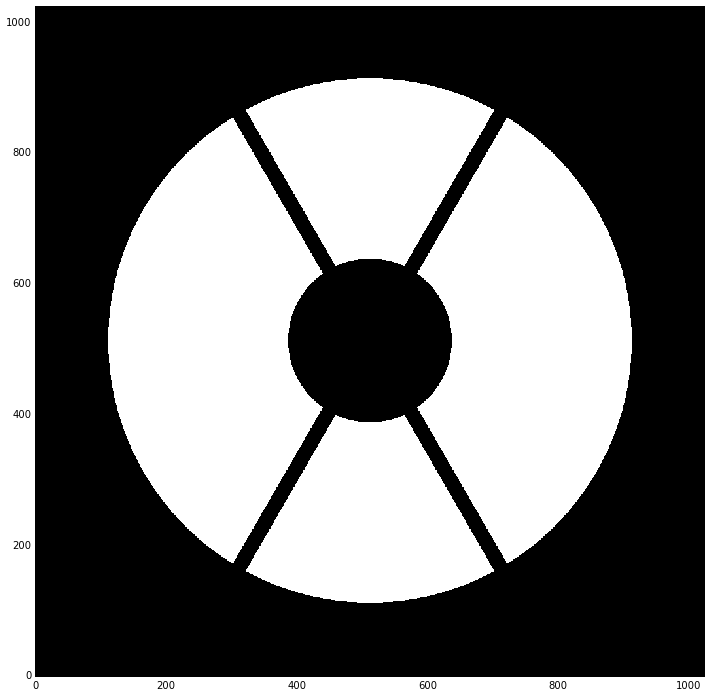

In [399]:
plt.figure(figsize=(12,12))
plt.imshow(Lyot_stop)

## Bin to final array resolution, crop

In [400]:
#scalefac = float(N)/(D/2)
#Lyot_stop_binned = skimage.transform.rescale(Lyot_stop, scalefac, order=1)

In [401]:
N_orig = D/2
scalefac = int(N_orig/N)
print("Binning the original aperture array {0:d}x".format(scalefac))
Lyot_stop_binned = np.reshape(Lyot_stop, (Lyot_stop.shape[0]/scalefac, scalefac, 
                                          Lyot_stop.shape[1]/scalefac, scalefac)).mean(1).mean(2)

Binning the original aperture array 4x


In [402]:
L_bin = Lyot_stop_binned.shape[0]
Lyot_stop_binned_quad = Lyot_stop_binned[L_bin/2:L_bin/2+N,L_bin/2:L_bin/2+N]
Lyot_stop_binned_quad_binary = np.round(Lyot_stop_binned_quad).astype(int)
Lyot_stop_binned_quad.shape

(125, 125)

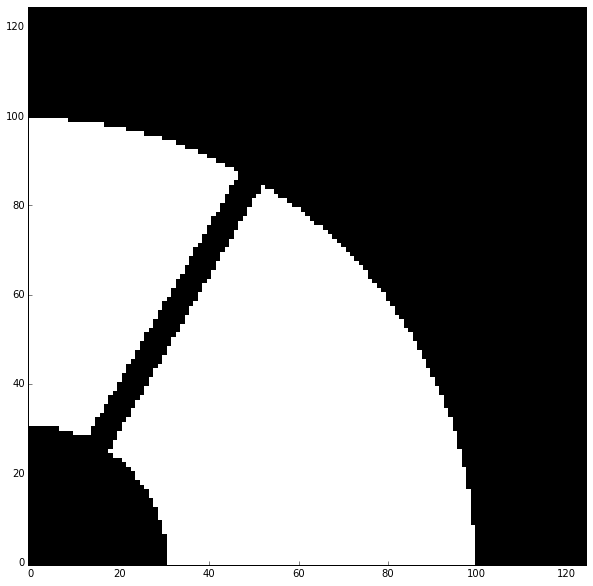

In [403]:
plt.figure(figsize=(10,10))
plt.imshow(Lyot_stop_binned_quad_binary)
#plt.imshow(np.floor(Lyot_stop_binned_quad))

## Write the binned, cropped Lyot stop to a dat (ASCII) file 

In [414]:
if centobs is True:
    LS_quart_dat_fname_tail = "LS_quart_ann{0:02d}D{1:02d}_{2:s}025cobs1Pad{3:02d}_N{4:04d}.dat".format(
                               int(round(100*inD)), int(round(100*outD)), secobs_key, spad, N)
else:
    LS_quart_dat_fname_tail = "LS_quart_ann{0:02d}D{1:02d}_{2:s}025cobs0Pad{3:02d}_N{4:04d}.dat".format(
                               int(round(100*inD)), int(round(100*outD)), secobs_key, spad, N)
    
LS_quart_dat_fname = os.path.join(LS_dir, LS_quart_dat_fname_tail)
#np.savetxt(LS_quart_dat_fname, Lyot_stop_binned_quad, fmt='%.6f', delimiter=" ")
np.savetxt(LS_quart_dat_fname, Lyot_stop_binned_quad_binary, fmt='%d', delimiter=" ")
print("Wrote binned, cropped LS array to {0:s}".format(LS_quart_dat_fname))

Wrote binned, cropped LS array to /astro/opticslab1/SCDA/Apertures/InputMasks/LS/LS_quart_ann25D80_X025cobs1Pad10_N0125.dat


In [415]:
os.listdir(LS_dir)

['LS_quart_ann25D85_X025cobs1Pad05_N0250.dat',
 'LDZ_quart_ann25D85_X025cobs1Pad05_tol02_N0250.dat',
 'LS_quart_ann20D85_X025cobs1Pad05_N0250.dat',
 'LS_quart_ann20D85_X025cobs1Pad10_N0250.dat',
 'LS_quart_ann25D85_X025cobs1Pad10_N0250.dat',
 'LS_quart_ann30D85_X025cobs1Pad10_N0250.dat',
 'LS_quart_ann30D85_X025cobs1Pad05_N0250.dat',
 'LDZ_quart_ann25D85_X025cobs1Pad10_tol05_N0250.dat',
 'LS_quart_ann25D80_X025cobs1Pad10_N0200.dat',
 'LDZ_quart_ann25D80_X025cobs1Pad10_tol05_N0200.dat',
 'LS_quart_ann25D80_X025cobs1Pad10_N0125.dat']

# Define Lyot plane dark zone

In [416]:
dz_width_fac = float(aligntol)/1000              # dark zone is +/- this fraction of pupil diameter
dz_width = np.ceil(2*N*dz_width_fac).astype(int) # dark zone is +/- this number of pixels in binned pupil array
print("Lyot plane dark zone width in binned array: +/- {:d} pixels".format(dz_width))

Lyot plane dark zone width in binned array: +/- 2 pixels


## Annular component

In [417]:
L = secobs.shape[0]
xs = np.linspace(-L/2 + 0.5, L/2 - 0.5, L)
[Xs, Ys] = np.meshgrid(xs, xs)

ann_outer_bound = np.ones(secobs.shape).astype(int)
inside = np.less_equal(Xs**2 + Ys**2, ((inD - 2*dz_width_fac)*D/2)**2)
outside = np.greater_equal(Xs**2 + Ys**2, ((outD + 2*dz_width_fac)*D/2)**2)
ann_outer_bound[inside] = 0
ann_outer_bound[outside] = 0

ann_inner_bound = np.ones(secobs.shape).astype(int)
inside = np.less_equal(Xs**2 + Ys**2, ((inD + 2*dz_width_fac)*D/2)**2)
outside = np.greater_equal(Xs**2 + Ys**2, ((outD - 2*dz_width_fac)*D/2)**2)
ann_inner_bound[inside] = 0
ann_inner_bound[outside] = 0

ann_stop = np.ones(secobs.shape).astype(int)
inside_stop = np.less_equal(Xs**2 + Ys**2, (inD*D/2)**2)
outside_stop = np.greater_equal(Xs**2 + Ys**2, (outD*D/2)**2)
ann_stop[inside] = 0
ann_stop[outside] = 0

In [418]:
ann_dz = np.logical_xor(ann_outer_bound, ann_inner_bound)
#plt.figure(figsize=(6,6))
#plt.imshow(ann_dark_zone)

## Secondary obscuration component

In [419]:
max_shift_outer = int(round(D*(spad_fac-dz_width_fac)))
shift_range_outer = range(-max_shift_outer,max_shift_outer+1,1)
[Xshifts_outer, Yshifts_outer] = np.meshgrid(shift_range_outer, shift_range_outer)
allowed_shifts_outer = np.less_equal(Xshifts_outer**2 + Yshifts_outer**2, max_shift_outer**2)
XYshifts_allowed_outer = zip(Xshifts_outer[allowed_shifts_outer], Yshifts_outer[allowed_shifts_outer])

max_shift_inner = int(round(D*(spad_fac+dz_width_fac)))
shift_range_inner = range(-max_shift_inner,max_shift_inner+1,1)
[Xshifts_inner, Yshifts_inner] = np.meshgrid(shift_range_inner, shift_range_inner)
allowed_shifts_inner = np.less_equal(Xshifts_inner**2 + Yshifts_inner**2, max_shift_inner**2)
XYshifts_allowed_inner = zip(Xshifts_inner[allowed_shifts_inner], Yshifts_inner[allowed_shifts_inner])

In [420]:
shift_secobs_accum_outer = np.ones(secobs.shape).astype(int)
for (xshift,yshift) in XYshifts_allowed_outer:
    shift_secobs = np.roll(np.roll(secobs, yshift, 0), xshift, 1)
    shift_secobs_accum_outer = np.logical_and(shift_secobs_accum_outer, shift_secobs)
    
shift_secobs_accum_inner = np.ones(secobs.shape).astype(int)
for (xshift,yshift) in XYshifts_allowed_inner:
    shift_secobs = np.roll(np.roll(secobs, yshift, 0), xshift, 1)
    shift_secobs_accum_inner = np.logical_and(shift_secobs_accum_inner, shift_secobs)

In [421]:
secobs_dz = np.logical_and(np.logical_xor(shift_secobs_accum_inner, shift_secobs_accum_outer), ann_inner_bound)
#plt.figure(figsize=(6,6))
#plt.imshow(secobs_dark_zone)

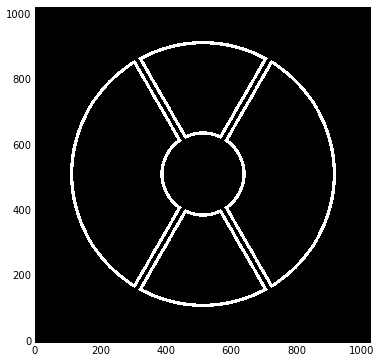

In [422]:
Lyot_dz = np.logical_and(np.logical_xor(ann_dz, secobs_dz), shift_secobs_accum_outer)
plt.figure(figsize=(6,6))
plt.imshow(Lyot_dz)

In [429]:
#Lyot_dz_binned = skimage.transform.rescale(Lyot_dz, scalefac, order=1)

print("Binning the original aperture array {0:d}x".format(scalefac))
Lyot_dz_binned = np.reshape(Lyot_dz, (Lyot_dz.shape[0]/scalefac, scalefac, 
                                      Lyot_dz.shape[1]/scalefac, scalefac)).mean(1).mean(2)

L_bin = Lyot_dz_binned.shape[0]
Lyot_dz_binned_quad = Lyot_dz_binned[L_bin/2:L_bin/2+N,L_bin/2:L_bin/2+N]
Lyot_dz_binned_quad_binary = np.round(Lyot_dz_binned_quad).astype(int)
Lyot_dz_binned_quad.shape

Binning the original aperture array 4x


(125, 125)

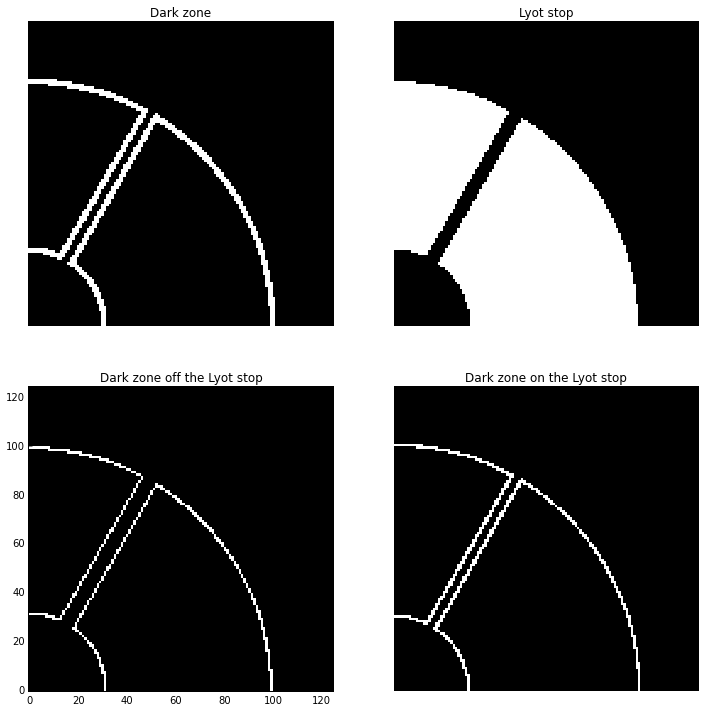

In [430]:
plt.figure(figsize=(12,12))
plt.subplot(221)
plt.title('Dark zone')
plt.imshow(Lyot_dz_binned_quad_binary)
plt.axis('off')
plt.subplot(222)
plt.title('Lyot stop')
plt.imshow(Lyot_stop_binned_quad_binary)
plt.axis('off')
plt.subplot(223)
plt.title('Dark zone off the Lyot stop')
plt.imshow(Lyot_stop_binned_quad_binary & Lyot_dz_binned_quad_binary)
plt.subplot(224)
plt.title('Dark zone on the Lyot stop')
plt.imshow(~Lyot_stop_binned_quad_binary & Lyot_dz_binned_quad_binary)
t=plt.axis('off')

## Alignment tolerance check

In [431]:
max_shift_tol = 2*N*dz_width_fac
max_shift_tol_int = int(np.floor(max_shift_tol))
test_shift = (0,1)
print("The LDZ accomomdates a translation {0:.1f}% of D={1:d} pixels = {2:.2f} pixels, up to {3:d} whole pixels".format(
      float(aligntol)/10, 2*N, max_shift_tol, max_shift_tol_int))
print("Testing an (x,y) translation of {0:} pixels. Beyond the design tolerance? {1:}".format(
      test_shift, test_shift[0]**2 + test_shift[1]**2 > max_shift_tol))
LS_halfplane = np.concatenate((Lyot_stop_binned_quad_binary[::-1,:], Lyot_stop_binned_quad_binary), axis=0)
LS_full = np.concatenate((LS_halfplane[:,::-1], LS_halfplane), axis=1)
LS_full_shift = np.roll(np.roll(LS_full, test_shift[0], axis=1), test_shift[1], axis=0)
LS_err_mask = np.ceil(np.abs(LS_full_shift - LS_full)).astype(bool)

LDZ_halfplane = np.concatenate((Lyot_dz_binned_quad_binary[::-1,:], Lyot_dz_binned_quad_binary), axis=0)
LDZ_full = np.concatenate((LDZ_halfplane[:,::-1], LDZ_halfplane), axis=1).astype(bool)

print("LDZ encompasses the LS transmission error region? {0:}".format(
        ~np.any(np.logical_and(LS_err_mask, ~LDZ_full))))

print("Total unconstrained \"leak\" area after translation = {0:d} pixels".format(
      int(np.sum(np.logical_and(LS_err_mask, ~LDZ_full)))))

The LDZ accomomdates a translation 0.5% of D=250 pixels = 1.25 pixels, up to 1 whole pixels
Testing an (x,y) translation of (0, 1) pixels. Beyond the design tolerance? False
LDZ encompasses the LS transmission error region? True
Total unconstrained "leak" area after translation = 0 pixels


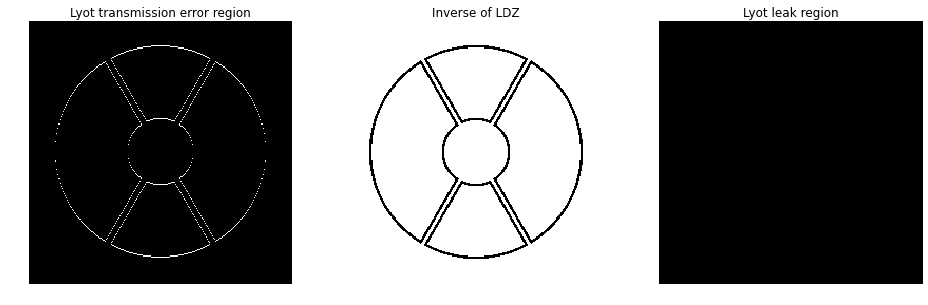

In [432]:
plt.figure(figsize=(16,6))
plt.subplot(131)
plt.imshow(LS_err_mask)
lims = plt.axis('off')
t=plt.title('Lyot transmission error region')
plt.subplot(132)
plt.imshow(~LDZ_full)
lims = plt.axis('off')
t=plt.title('Inverse of LDZ')
plt.subplot(133)
plt.imshow(np.logical_and(LS_err_mask, ~LDZ_full))
lims = plt.axis('off')
t=plt.title('Lyot leak region')

## Write the Lyot dark zone file

In [433]:
if aligntol > 0:
    if centobs is True:
        LDZ_quart_dat_fname_tail = "LDZ_quart_ann{0:02d}D{1:02d}_{2:s}025cobs1Pad{3:02d}_tol{4:02d}_N{5:04d}.dat".format(
                                   int(round(100*inD)), int(round(100*outD)), secobs_key, spad, aligntol, N)
    else:
        LDZ_quart_dat_fname_tail = "LDZ_quart_ann{0:02d}D{1:02d}_{2:s}025cobs0Pad{3:02d}_tol{4:02d}_N{5:04d}.dat".format(
                                   int(round(100*inD)), int(round(100*outD)), secobs_key, spad, aligntol, N)
    LDZ_quart_dat_fname = os.path.join(LS_dir, LDZ_quart_dat_fname_tail)
    np.savetxt(LDZ_quart_dat_fname, Lyot_dz_binned_quad_binary, fmt='%d', delimiter=" ")
    print("Wrote binned, cropped LDZ array to {0:s}".format(LDZ_quart_dat_fname))

Wrote binned, cropped LDZ array to /astro/opticslab1/SCDA/Apertures/InputMasks/LS/LDZ_quart_ann25D80_X025cobs1Pad10_tol05_N0125.dat


In [434]:
os.listdir(LS_dir)

['LS_quart_ann25D85_X025cobs1Pad05_N0250.dat',
 'LDZ_quart_ann25D85_X025cobs1Pad05_tol02_N0250.dat',
 'LS_quart_ann20D85_X025cobs1Pad05_N0250.dat',
 'LS_quart_ann20D85_X025cobs1Pad10_N0250.dat',
 'LS_quart_ann25D85_X025cobs1Pad10_N0250.dat',
 'LS_quart_ann30D85_X025cobs1Pad10_N0250.dat',
 'LS_quart_ann30D85_X025cobs1Pad05_N0250.dat',
 'LDZ_quart_ann25D85_X025cobs1Pad10_tol05_N0250.dat',
 'LS_quart_ann25D80_X025cobs1Pad10_N0200.dat',
 'LDZ_quart_ann25D80_X025cobs1Pad10_tol05_N0200.dat',
 'LS_quart_ann25D80_X025cobs1Pad10_N0125.dat',
 'LDZ_quart_ann25D80_X025cobs1Pad10_tol05_N0125.dat']